# World Data League 2023

## 🎯 Challenge
Determining The Main Mobility Flows in the City of Lisbon Based on Mobile Device Data


## Team: Random Graphers
## 👥 Authors
* José Almeida
* Juliana Machado
* Marta Colaço
* Rui Santos

## 💻 Development

### Package installation and imports

We use the Pytorch Geometric Temporal package since it contains models and functions capable of dealing with both temporal and spatial information (which is the case of traffic flow). More specifically, it contains models based on Graph Neural Networks with blocks like Gated Recurrent Units or Long Short Term Memory which are capable of predicting spatio-temporal signals.

In [1]:
!pip install numpy matplotlib pandas seaborn torch torch-geometric-temporal # it takes a while to install

In [2]:
import os
import torch
import torch.nn.functional as F
import torch_geometric_temporal
from torch_geometric_temporal.nn.recurrent import A3TGCN2
from torch_geometric_temporal.signal import StaticGraphTemporalSignal
from torch_geometric_temporal.signal import temporal_signal_split

from tqdm import tqdm
import datetime
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import date

file_path = 'ficheiros_WDL'
folder_path = 'DISPOSITIVOS MOVEIS_GRELHA E EIXOS'

### EDA

#### Loading data

In [3]:
csv_path = 'CML_DISPOSITIVOS MOVEIS_GRELHA_indCD15m_2022_09_0001_4000.csv'
september = pd.read_csv(os.path.join(file_path, folder_path, csv_path)).iloc[:,:3] # we are going to use only C1 but in the future it would be interesting to test more features

csv_path = 'CML_DISPOSITIVOS MOVEIS_GRELHA_indCD15m_2022_10_0001_4000.csv'
october = pd.read_csv(os.path.join(file_path, folder_path, csv_path)).iloc[:,:3]

csv_path = 'CML_DISPOSITIVOS MOVEIS_GRELHA_indCD15m_2022_11_0001_4000.csv'
november = pd.read_csv(os.path.join(file_path, folder_path, csv_path)).iloc[:,:3]

months = pd.concat((september, october, november))

In [4]:
quadriculas_df = pd.read_excel(os.path.join(file_path,
                                            "DISPOSITIVOS MOVEIS_QUADRICULAS",
                                            "DISPOSITIVOS MOVEIS_QUADRICULAS.xlsx"))

all_lat = np.unique(quadriculas_df["latitude"])
all_lon = np.unique(quadriculas_df["longitude"])
n_grid_lat = len(all_lat)
n_grid_lon = len(all_lon)

map_lat_to_rank = {k:k_ for k,k_ in zip(all_lat,np.argsort(all_lat))}
map_lon_to_rank = {k:k_ for k,k_ in zip(all_lon,np.argsort(all_lon))}

quadriculas_dict = {i:((lat,lon),(map_lat_to_rank[lat],map_lon_to_rank[lon]))
                    for i,lat,lon in zip(quadriculas_df["grelha_id"],
                                         quadriculas_df["latitude"],
                                         quadriculas_df["longitude"])}

#### Linearizing time

In [5]:
def get_time_of_day(datetime_col):
    # gets time of day (value between 0 and 1, 0 corresponding to 00:00
    # and 1 corresponding to 23:59:999999). This enables us to use the time
    # of day as a continuous and linear value. this expects the datetime to
    # be formatted as YYYY-MM-DD?HH:MM:SS where ? is any given character
    def hour_minute_to_tod(hour,minute):
        return hour / 24 + minute / (24 * 60)

    tod = np.zeros([len(datetime_col),2],dtype=int)
    for i,x in enumerate(tqdm(datetime_col)):
        x = x[11:16]
        tod[i] = [int(x[:2]),int(x[3:])]
    hour = tod[:,0]
    minute = tod[:,1]
    tod_norm = hour_minute_to_tod(hour,minute)
    return tod_norm

def get_weekend(datetime_col):
    # checks whether a day is on a weekend or not
    is_weekend = np.zeros([len(datetime_col),2],dtype=bool)
    for i,x in enumerate(tqdm(datetime_col)):
        # monday is 0, saturday is 5, sunday is 6
        x = datetime.date(int(x[0:4]),int(x[5:7]),int(x[8:10])).weekday() > 4
        is_weekend[i] = x
    return is_weekend

def get_tod_and_weekend(datetime_col):
    # combines get_time_of_day and get_weekend in a single for loop
    def hour_minute_to_tod(hour,minute):
        return hour / 24 + minute / (24 * 60)

    tod = np.zeros([len(datetime_col),2],dtype=int)
    is_weekend = np.zeros([len(datetime_col)],dtype=bool)
    for i,x in enumerate(tqdm(datetime_col)):
        is_weekend[i] = datetime.date(int(x[0:4]),int(x[5:7]),int(x[8:10])).weekday() > 4
        x = x[11:16]
        tod[i] = [int(x[:2]),int(x[3:])]
    hour = tod[:,0]
    minute = tod[:,1]
    tod_norm = hour_minute_to_tod(hour,minute)
    return tod_norm,is_weekend

def to_time(x):
    # gets the time from the datetime column. this expects the datetime to
    # be formatted as YYYY-MM-DD?HH:MM:SS where ? is any given character
    year = int(x[0:4])
    month = int(x[5:7])
    day = int(x[8:10])
    hour = int(x[11:13])
    minute = int(x[14:])
    d = date(year, month, day)
    yday = (d - date(year, 1, 1)).days
    weekday = d.weekday()
    return year,month,day,hour,minute,yday,weekday

def hour_to_fraction(hour,minutes):
    # converts hours and minutes to a fraction (same as get_time_of_day)
    hour = hour / 24
    minutes = minutes / 60 / 24
    return hour + minutes

In [6]:
base_unit_time = hour_to_fraction(0,15)

datetimes = [to_time(x[:-8])
             for x in months["Datetime"]]
months["year"] = [x[0] for x in datetimes]
months["month"] = [x[1] for x in datetimes]
months["day"] = [x[2] for x in datetimes]
months["hour"] = [x[3] for x in datetimes]
months["minute"] = [x[4] for x in datetimes]
months["yday"] = [x[5] for x in datetimes]
months["weekday"] = [x[6] for x in datetimes]
months["linear_time"] = months["yday"] + hour_to_fraction(months["hour"],months["minute"])
months["linear_time"] = months["linear_time"] / base_unit_time
months["linear_time"] = months["linear_time"].astype(int)
months["linear_time"] = months["linear_time"] - months["linear_time"].min()

print("Retrieving coords")
months["lat_real"] = [quadriculas_dict[k][0][0] for k in months["Grid_ID"]]
months["lon_real"] = [quadriculas_dict[k][0][1] for k in months["Grid_ID"]]
months["lat"] = [quadriculas_dict[k][1][0] for k in months["Grid_ID"]]
months["lon"] = [quadriculas_dict[k][1][1] for k in months["Grid_ID"]]

Retrieving coords


#### Visualizing

Here, we display two crucial aspects of our data:

* Whenever we have a weekend (weekday 0 is Monday and weekday 6 is Sunday), permanence on squares drops dramatically
* Over the day, the permance changes consistently, aligning with an earlier rush hour and slowly decaying during the last third of the day

In [7]:
data_to_observe = months.groupby(["weekday","hour","minute"]).agg({"C1":np.mean}).reset_index()
data_to_observe["Time of day"] = hour_to_fraction(data_to_observe["hour"],
                                                  data_to_observe["minute"])

<Axes: xlabel='Time of day', ylabel='C1'>

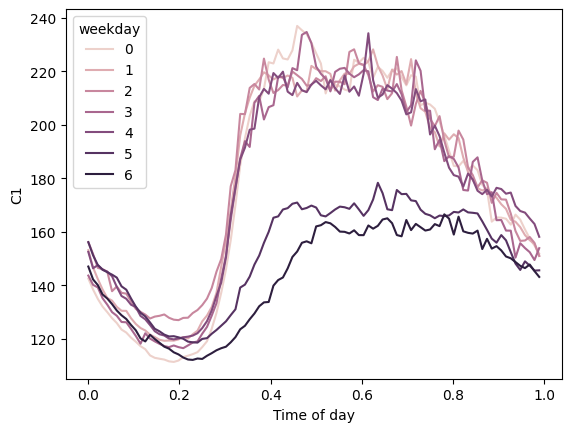

In [8]:
sns.lineplot(x="Time of day",y="C1",data=data_to_observe,hue="weekday")

At this stage, we also observe 3 clear outliers due to technical error, showing over 40,000 terminals in places where this makes no sense (to confirm this, we individually inspected the latitude and longitude, observing that such a large spike was impossible at these spots, particularly when no specific event was happening at the time) -- we correct them by setting them to the average C1 level. While other place show high occupancy (> 20K), these are attributable to football games as they are colocalized with football stadiums and happen during football games.

In [9]:
def print_full(x):
    # prints the whole dataframe
    pd.set_option('display.max_rows', len(x))
    print(x)
    pd.reset_option('display.max_rows')

print_full(months[months["C1"] > 40000][
    ["Datetime","Grid_ID","lat_real","lon_real","C1"]].sort_values("C1"))

                         Datetime  Grid_ID   lat_real  lon_real             C1
7359995  2022-09-19T22:15:00.000Z     2599  38.759373 -9.189095   41742.101562
3058930  2022-09-15T22:30:00.000Z     1081  38.724340 -9.147772   73391.531250
3058932  2022-09-15T22:45:00.000Z     1081  38.724340 -9.147772  133676.406250
1244164  2022-09-15T22:45:00.000Z      440  38.708920 -9.174722  313284.093750


Finally, we provide a small observable picture of data moving through time, which also inspired our approach. Of note is the consistent and spatially correlated changes one observes. (this is editable --- `time_steps` determines how many time points are shown). 

In the documentation below we mention "linear time". This quantity simply refers to a measure of time where days are units, starting at a given arbitrary date (in our case the beginning of September) and anything below a day is encoded as a fraction. For example - September 2nd at 12:00 would be 1.5. This allows us to correctly order everything as a continuous grid and easily visualize these data as a grid.

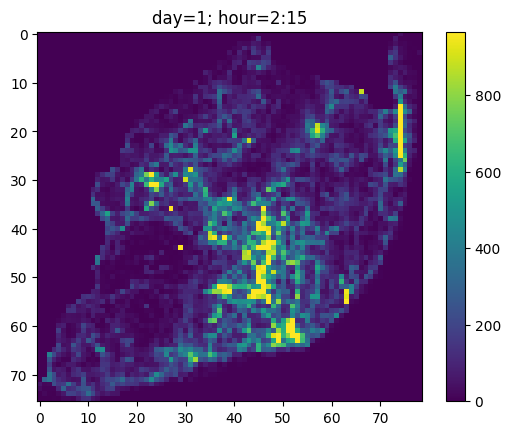

In [10]:
time_of_day_norm = 96
weekday_base = 3
time_steps = 10
time_step_size = 1
starting_time_step = 48

def linear_time_to_week_day(t,base=0):
    # converts linear time to weekday
    if isinstance(t,(list,int)):
        t = np.array(t)
    div = (96 * 7)
    t = ((t % div) // 96 + base) % 7
    t = t[:,np.newaxis].astype(np.float32)
    return t

def linear_time_to_time_of_day(t,base=0):
    # converts linear time to time of day
    if isinstance(t,(list,int)):
        t = np.array(t)
    t = (t % time_of_day_norm) / time_of_day_norm
    t = t[:,np.newaxis].astype(np.float32)
    return t

def linear_time_to_is_weekend(t,base=0):
    # checks from linear whether or not a day belongs to the weekend
    return np.where(
        linear_time_to_week_day(t,base) >= 5,1,0)
    
import pylab as pl
import time
from IPython import display
from matplotlib import pyplot as plt

times = months["linear_time"]
lat = np.array(months["lat"])
lon = np.array(months["lon"])
weekend = months["weekday"] >= 5
data_values = np.array(months[["C1"]],
                       dtype=np.float32)

data_array = np.zeros([times.max() + 1,data_values.shape[1],
                       n_grid_lat,n_grid_lon],
                      dtype=np.float32)

data_array[times,:data_values.shape[1],lat,lon] = data_values

# remove very obvious outliers
for t,d,latitude,longitude in zip(*np.where(data_array > 50000)):
    possible_values = data_array[:t,d,latitude,longitude]
    possible_values = possible_values[possible_values < 50000]
    new_value = possible_values[-1]
    data_array[t,d,latitude,longitude] = new_value

data_array.shape[0]

for i in range(0,time_steps):
    pl.imshow(data_array[starting_time_step + int(i*time_step_size),0,::-1],
              vmin=0,vmax=np.quantile(data_array[:,0,:,:],0.99))
    plt.colorbar()
    minutes_day = (i % 96) / 96 * (24*60)
    hours = int(minutes_day // 60)
    minutes = int(minutes_day % 60)
    day_of_month = i // 96 + 1
    plt.title("day={}; hour={}:{}".format(day_of_month,hours,minutes))
    display.clear_output(wait=True)
    display.display()
    plt.show()
    time.sleep(0.001)

### Data processing
We followed a combined approach regarding data processing. Firstly, we decided to simplify the main dataset containing mobile device data for the Lisbon city grid. We did that by joining 200x200m squares into bigger squares with 1000x1000m. We then computed the features for the bigger squares by averaging the smaller squares inside for each time period. Then, we cross-referenced the abovementioned dataset with the road network of Lisbon to select only squares that contained roads. We also checked which squares had roads connecting them, in order to define the edges for the graph model.

#### Big square dataset

In [11]:
### Form new grid with big squares

coords = pd.read_excel(os.path.join('ficheiros_WDL',
                                    'DISPOSITIVOS MOVEIS_QUADRICULAS',
                                    'DISPOSITIVOS MOVEIS_QUADRICULAS.xlsx')) # read coordinates of squares
coords = coords.loc[:, ['grelha_id', 'latitude', 'longitude']] # select desired columns

lat = np.unique(coords['latitude'])[::-1] # find unique latitude values
lon = np.unique(coords['longitude']) # find unique longitude values

idx_grid = np.zeros((len(lat), len(lon)), dtype=np.uint16) # create grid to allocate square indices

for idx in range(len(coords)):
    
    i = np.where(lat==coords.loc[idx, 'latitude'])[0]
    j = np.where(lon==coords.loc[idx, 'longitude'])[0]
    
    idx_grid[i, j] = coords.loc[idx, 'grelha_id']

new_grid = np.zeros((len(lat), len(lon)), dtype=np.uint8) # grid to place new indices after joining squares
squares = [] # dataset with new and old square indices and center coordinates of big squares

idx = 1
for i in range(2, len(lat)-2, 5): 
    for j in range(2, len(lon)-2, 5):
        
        subgrid = idx_grid[i-2:i+3, j-2:j+3] # find 5x5 grid to form big square
        
        if np.all(subgrid): # check if every spot on the subgrid contains a square
            
            squares.append([idx, list(subgrid.flatten()), lat[i], lon[j]])
            
            new_grid[i, j] = idx
            idx += 1

new_grid = new_grid[2:-2:5, 2:-2:5] # subsample new_grid to get valid positions of big squares  
squares = pd.DataFrame(squares, columns=['square_id', 'grid_ids', 'latitude', 'longitude'])

adjacency = [] # dataset to save neighbors of each square (to form graph edges)
h, w = new_grid.shape

for i in range(h):
    for j in range(w):
        
        if new_grid[i,j]!=0: # Check if square exists
            
            hmin = new_grid[max(0, i-1), j] # neighbor below
            hmax = new_grid[min(i+1, h-1), j] # neighbor on top
            wmin = new_grid[i, max(0, j-1)] # neighbor on the left
            wmax = new_grid[i, min(j+1, w-1)] # neighbor on the right

            neighbors = [neighbor for neighbor in [hmin, hmax, wmin, wmax] if neighbor!=0 and neighbor!=new_grid[i, j]] # get valid neighbors

            adjacency.append([new_grid[i, j], neighbors])
        
adjacency = pd.DataFrame(adjacency, columns=['square_id', 'neighbors'])

#### Road dataset

To understand whether each road is contained within a grid cell, we access the resources provided by Câmara Municipal de Lisboa. Particularly, we access the resources available here in this link: https://dadosabertos.cm-lisboa.pt/dataset/rede-viaria-escala-1-20000/resource/616c663f-b951-4fe7-aa6c-d1e5050ef0f7.

In [12]:
import json
import os
import requests
import numpy as np
import pandas as pd
from tqdm import tqdm

# got this from chatgpt but confirmed it
def distance_points_to_segments(A, B, C):
    """Calculates the distance between points in A and line segments defined by points in B and C."""
    A = np.asarray(A)
    B = np.asarray(B)
    C = np.asarray(C)

    AB = B[:, np.newaxis, :] - A
    AC = C[:, np.newaxis, :] - A
    BC = C[:, np.newaxis, :] - B[:, np.newaxis, :]

    dotABAC = np.sum(AB * AC, axis=2)
    dotBCAC = np.sum(BC * AC, axis=2)

    outside_segment = dotABAC * dotBCAC > 0

    distAB = np.linalg.norm(AB, axis=2)
    distAC = np.linalg.norm(AC, axis=2)
    distBC = np.linalg.norm(BC, axis=2)

    closest_dist = np.minimum(distAB, np.minimum(distAC, distBC))
    dist = np.where(outside_segment, 
                    closest_dist, 
                    np.abs(np.cross(AB, AC, axis=2)) / np.linalg.norm(AB, axis=2))

    return dist

path_to_data = "/Users/josegcpa/Downloads/ficheiros_WDL/"
quadriculas_path = os.path.join(path_to_data,
                                "DISPOSITIVOS MOVEIS_QUADRICULAS",
                                "DISPOSITIVOS MOVEIS_QUADRICULAS.xlsx")

quadriculas_df = pd.read_excel(quadriculas_path)

all_lat = np.unique(quadriculas_df["latitude"])
all_lon = np.unique(quadriculas_df["longitude"])
n_grid_lat = len(all_lat)
n_grid_lon = len(all_lon)

map_lat_to_rank = {k:k_ for k,k_ in zip(all_lat,np.argsort(all_lat))}
map_lon_to_rank = {k:k_ for k,k_ in zip(all_lon,np.argsort(all_lon))}

quadriculas_dict = {i:((lat,lon),(map_lat_to_rank[lat],map_lon_to_rank[lon]))
                    for i,lat,lon in zip(quadriculas_df["grelha_id"],
                                         quadriculas_df["latitude"],
                                         quadriculas_df["longitude"])}

url = "https://services.arcgis.com/1dSrzEWVQn5kHHyK/arcgis/rest/services/CartografiaBase/FeatureServer/1/query?outFields=*&where=1%3D1&f=geojson"
roads = requests.get(url).json()
all_quads = sorted(quadriculas_dict.keys())
quadriculas_arr = np.array([quadriculas_dict[i][0] 
                            for i in all_quads])
min_quad_diff = np.abs(np.diff(np.sort(np.unique(quadriculas_arr[:,0])))).max()
quadriculas_quant_arr = np.array([quadriculas_dict[i][1] 
                                  for i in all_quads])
n_quad = quadriculas_df["grelha_id"].max()

road_quad_list = []
edge_list = []
for road in tqdm(roads["features"]):
    try:
        R = np.array(road["geometry"]["coordinates"])
    except:
        R = []
        for r in road["geometry"]["coordinates"]:
            R.extend(np.array(r))
        R = np.concatenate(R)
    if len(R.shape) == 1:
        R = np.stack([R[0::2],R[1::2]],1)
    # switch axes to make compliant with lat,lon 
    R = np.stack([R[:,1],R[:,0]],1)
    distances = distance_points_to_segments(quadriculas_arr,R[:-1],R[1:])
    for idx in range(distances.shape[0]-1):
        d_curr = distances[idx,:]
        d_next = distances[idx+1,:]
        d_curr[d_curr > min_quad_diff*2] = np.nan
        d_next[d_next > min_quad_diff*2] = np.nan
        if np.any(~np.isnan(d_curr)) and np.any(~np.isnan(d_curr)):
            q_curr = all_quads[np.nanargmin(d_curr)]
            q_next = all_quads[np.nanargmin(d_next)]
            if q_curr is not None:
                road_quad_list.append(q_curr)
            if q_next is not None:
                road_quad_list.append(q_next)
                
            if (q_curr is not None) and (q_next is not None):
                if q_curr != q_next:
                    edge = (q_curr,q_next)
                    if edge not in edge_list:
                        edge_list.append(edge)

data_roads = list(set(road_quad_list))

100%|██████████| 1000/1000 [00:02<00:00, 415.61it/s]


In [13]:
### Edit dataset 

for idx in range(len(squares)):
    
    grids = squares.iloc[idx]['grid_ids'] # get small squares that form big square
    subset = months[months['Grid_ID'].isin(grids)] # get subset of data for group of small squares
    
    values = subset.groupby(by='Datetime')['C1'].mean().reset_index() # group small squares by time period and average mobile device data
    values.insert(0, 'square_id', [squares.iloc[idx]['square_id'] for _ in range(len(values))]) # insert column with big square IDs
    
    if idx == 0:
        data = values
    else:
        data = pd.concat((data, values))

In [14]:
### Create edges

edge_indices = [] # create array of shape [2, number of nodes] to represent edges

for i in range(len(adjacency)):
    line = adjacency.iloc[i] 
    square = line['square_id']
    #neighbors = eval(line['neighbors'])
    neighbors = line['neighbors']

    for neighbor in neighbors:
        pair = [min(square-1, neighbor-1), max(square-1, neighbor-1)] # order pair of nodes
        if pair not in edge_indices: # check if not already on the list
            edge_indices.append(pair)

edge_indices = np.array(edge_indices)
edge_indices = np.transpose(edge_indices) # transpose to get the desired shape
print(edge_indices)
print(edge_indices.shape)

[[  0   1   1   2   2   3   3   4   4   5   6   6   7   7   8   8   9   9
   10  10  11  11  12  12  13  14  14  15  15  16  16  17  17  18  18  19
   19  20  20  21  21  22  22  23  23  24  25  25  26  26  27  27  28  28
   29  29  30  30  31  31  32  32  33  33  34  34  35  36  36  37  37  38
   38  39  39  40  40  41  41  42  42  43  43  44  44  45  45  46  46  47
   48  48  49  49  50  50  51  51  52  52  53  53  54  54  55  55  56  56
   57  57  58  58  60  60  61  61  62  62  63  63  64  64  65  65  66  66
   67  67  68  68  69  69  70  71  71  72  72  73  73  74  74  75  75  76
   76  77  77  78  78  79  79  80  80  82  82  83  83  84  84  85  85  86
   86  87  87  88  88  89  89  90  90  92  92  93  93  94  94  95  95  96
   96  97  97  98  98  99  99 100 100 102 102 103 103 104 104 105 105 106
  106 107 107 108 109 110 112 112 113 113 114 115 116 118]
 [  2   8   2   9   3  10   4  11   5  12  15   7  16   8  17   9  18  10
   19  11  20  12  21  13  22  25  15  26  16  27  17

In [15]:
# Add time of day, whether it's a weekend day or if it's a road

tod,is_weekend = get_tod_and_weekend(months["Datetime"])
months["Is_road"] = np.in1d(months["Grid_ID"],data_roads)
months["Time_of_day"] = tod
months["Is_weekend"] = is_weekend
print(months.head())

100%|██████████| 30881257/30881257 [00:36<00:00, 850111.81it/s]


   Grid_ID                  Datetime     C1  year  month  day  hour  minute  \
0        1  2022-09-07T12:30:00.000Z   3.69  2022      9    7    12      30   
1        1  2022-09-07T22:30:00.000Z   0.00  2022      9    7    22      30   
2        1  2022-09-07T23:00:00.000Z   0.00  2022      9    7    23       0   
3        1  2022-09-07T18:00:00.000Z  15.72  2022      9    7    18       0   
4        1  2022-09-07T06:30:00.000Z   3.86  2022      9    7     6      30   

   yday  weekday  linear_time   lat_real  lon_real  lat  lon  Is_road  \
0   249        2          626  38.692094 -9.225027    0    3    False   
1   249        2          666  38.692094 -9.225027    0    3    False   
2   249        2          668  38.692094 -9.225027    0    3    False   
3   249        2          648  38.692094 -9.225027    0    3    False   
4   249        2          602  38.692094 -9.225027    0    3    False   

   Time_of_day  Is_weekend  
0     0.520833       False  
1     0.937500       False  

In [16]:
new_df = {"Grid_ID":[],"New_Square_ID":[]}
for i,row in squares.iterrows():
    square_id = row["square_id"]
    grid_ids = row["grid_ids"]
    
    new_df["Grid_ID"].extend(grid_ids)
    new_df["New_Square_ID"].extend([square_id for _ in grid_ids])
    
new_idx_df = pd.DataFrame.from_dict(new_df)

months_new = months.merge(new_idx_df,on="Grid_ID")

months_agg = (months_new.groupby(["Datetime","New_Square_ID"])
 .agg({
     "C1":np.mean,
     "Is_road":np.any,
     "Is_weekend":np.any,
     "Time_of_day":np.mean
 }))

months_agg = months_agg.reset_index().sort_values(["Datetime","New_Square_ID"])

months_agg["Grid_ID"] = months_agg["New_Square_ID"]

In [17]:
from tqdm import trange

nodes = np.unique(months_agg['Grid_ID'])
n_nodes = len(nodes)
graphs = []
tod_features = []
we_features = []
road_features = []

for i in trange(0, len(months_agg), n_nodes):
    graph = np.array(months_agg.iloc[i:i+n_nodes]['C1'])
    graph = graph - graph.min()
    graph = graph / graph.max()
    graphs.append(list(graph))
    tod_features.append(list(months_agg.iloc[i:i+n_nodes]['Time_of_day']))
    we_features.append(list(months_agg.iloc[i:i+n_nodes]['Is_weekend']))
    road_features.append(list(months_agg.iloc[i:i+n_nodes]['Is_road']))

100%|██████████| 8253/8253 [00:01<00:00, 6508.92it/s]


In [18]:
train_step = 5
test_step = 5

# allocate memory 
r = train_step + test_step
sample_size_out_train = len(graphs) // r 
sample_size_out_test = len(graphs) // r 
train_sh = sample_size_out_train,len(graphs[0]),train_step
test_sh = sample_size_out_test,len(graphs[0]),test_step
node_features = np.zeros(train_sh)
node_features_tod = np.zeros(train_sh)
node_features_we = np.zeros(train_sh)
node_features_road = np.zeros(train_sh)
node_labels = np.zeros(test_sh)

# assign
i = 0
while i+train_step+test_step < len(graphs):
    node_features[i // r] = np.transpose(np.array(graphs[i:i+train_step]))
    node_features_tod[i // r] = np.transpose(np.array(tod_features[i:i+train_step]))
    node_features_we[i // r] = np.transpose(np.array(we_features[i:i+train_step]))
    node_features_road[i // r] = np.transpose(np.array(road_features[i:i+train_step]))

    node_labels[i // r] = np.transpose(np.array(graphs[i+train_step:i+train_step+test_step]))

    i += train_step+test_step

print(node_features.shape)
print(node_labels.shape)

node_features = np.stack([node_features,
                          node_features_tod,
                          node_features_we,
                          node_features_road],2)

# remove outliers
node_features[:,:,0,:] = np.where(node_features[:,:,0,:] > 20,
                                  np.mean(node_features[:,:,0,:]),
                                  node_features[:,:,0,:])

print(node_features.shape)
print(node_labels.shape)

(825, 120, 5)
(825, 120, 5)
(825, 120, 4, 5)
(825, 120, 5)


In [19]:
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

In [20]:
### Separate dataset and create dataloaders

edge_weights = np.ones(edge_indices.shape[1]) # we define edge weights as being all the same

dataset = StaticGraphTemporalSignal(edge_index=edge_indices, edge_weight=edge_weights, # method used to create dataset (does not support batches, so we create dataloaders below)
                                    features=node_features, targets=node_labels)  

train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.8) # split dataset into train and test

device = torch.device(device)
batch_size = 32

train_input = np.array(train_dataset.features) 
train_target = np.array(train_dataset.targets) 
train_x_tensor = torch.from_numpy(train_input).type(torch.FloatTensor).to(device)  
train_target_tensor = torch.from_numpy(train_target).type(torch.FloatTensor).to(device)  
train_dataset_new = torch.utils.data.TensorDataset(train_x_tensor, train_target_tensor)
train_loader = torch.utils.data.DataLoader(train_dataset_new, batch_size=batch_size, shuffle=True, drop_last=True) # create train dataloader

test_input = np.array(test_dataset.features) 
test_target = np.array(test_dataset.targets) 
test_x_tensor = torch.from_numpy(test_input).type(torch.FloatTensor).to(device)  
test_target_tensor = torch.from_numpy(test_target).type(torch.FloatTensor).to(device) 
test_dataset_new = torch.utils.data.TensorDataset(test_x_tensor, test_target_tensor)
test_loader = torch.utils.data.DataLoader(test_dataset_new, batch_size=batch_size, shuffle=False) # create test dataloader

### Define and train model


We use an Attention Temporal Graph Convolutional Network (A3TGCN) (paper: https://www.mdpi.com/2220-9964/10/7/485). Essentially, this method combines the ability of graph convolutional neural networks (GCN) to model space with gated recurrent units (GRU) to model time. Additionally, this model also incorporates attention, allowing the model to learn which time point is the most relevant for prediction.

In [21]:
### Define architecture

class TemporalGNN(torch.nn.Module):
    def __init__(self, node_features, out_channels, periods, batch_size):
        super(TemporalGNN, self).__init__()
        # Attention Temporal Graph Convolutional Cell
        self.tgnn = A3TGCN2(in_channels=node_features, # Graph convolutional network with attention
                            out_channels=out_channels, 
                            periods=periods,
                            batch_size=batch_size)
        self.linear = torch.nn.Linear(out_channels, periods)
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, x, edge_index):
        """
        x = Node features for T time steps
        edge_index = Graph edge indices
        """
        h = self.tgnn(x, edge_index)
        h = F.relu(h)
        h = self.linear(h)
        h = self.sigmoid(h)
        return h

In [22]:
# Create model and optimizers
n_epochs = 50
model = TemporalGNN(node_features=node_features.shape[2],
                    out_channels=32,
                    periods=train_step,
                    batch_size=32).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,patience=3,verbose=True,min_lr=1e-6)
loss_fn = torch.nn.MSELoss()
model.train()

for snapshot in train_dataset:
    static_edge_index = snapshot.edge_index.to(device)
    break

count = -1
max_count = 5
for epoch in range(n_epochs):
    loss_list = []
    with tqdm(train_loader, unit="batch") as tepoch:
         for encoder_inputs, labels in tepoch:
             tepoch.set_description(f"Epoch {epoch}")
             y_hat = model(encoder_inputs, static_edge_index)     
             loss = loss_fn(y_hat, labels) 
             loss.backward()
             optimizer.step()
             optimizer.zero_grad()
             loss_list.append(loss.item())
             tepoch.set_postfix(loss=loss.item())
         
    print("Epoch {} train RMSE: {:.4f}".format(epoch, sum(loss_list)/len(loss_list)))
    scheduler.step(sum(loss_list)/len(loss_list))
    if epoch==0:
        prev_loss = sum(loss_list)/len(loss_list)
    if prev_loss <= sum(loss_list)/len(loss_list):
        count += 1
        if count == max_count:
            break
    else:
        prev_loss = sum(loss_list)/len(loss_list)
        count = 0

Epoch 0: 100%|██████████| 20/20 [00:00<00:00, 27.24batch/s, loss=0.038] 


Epoch 0 train RMSE: 0.0578


Epoch 1: 100%|██████████| 20/20 [00:00<00:00, 28.53batch/s, loss=0.0162]


Epoch 1 train RMSE: 0.0285


Epoch 2: 100%|██████████| 20/20 [00:00<00:00, 31.00batch/s, loss=0.0102] 


Epoch 2 train RMSE: 0.0115


Epoch 3: 100%|██████████| 20/20 [00:00<00:00, 28.09batch/s, loss=0.00992]


Epoch 3 train RMSE: 0.0092


Epoch 4: 100%|██████████| 20/20 [00:00<00:00, 29.69batch/s, loss=0.00883]


Epoch 4 train RMSE: 0.0086


Epoch 5: 100%|██████████| 20/20 [00:00<00:00, 29.53batch/s, loss=0.00699]


Epoch 5 train RMSE: 0.0084


Epoch 6: 100%|██████████| 20/20 [00:00<00:00, 28.89batch/s, loss=0.00836]


Epoch 6 train RMSE: 0.0083


Epoch 7: 100%|██████████| 20/20 [00:00<00:00, 28.62batch/s, loss=0.00738]


Epoch 7 train RMSE: 0.0081


Epoch 8: 100%|██████████| 20/20 [00:00<00:00, 29.47batch/s, loss=0.00944]


Epoch 8 train RMSE: 0.0080


Epoch 9: 100%|██████████| 20/20 [00:00<00:00, 26.60batch/s, loss=0.00716]


Epoch 9 train RMSE: 0.0081


Epoch 10: 100%|██████████| 20/20 [00:00<00:00, 29.51batch/s, loss=0.00711]


Epoch 10 train RMSE: 0.0080


Epoch 11: 100%|██████████| 20/20 [00:00<00:00, 29.96batch/s, loss=0.00701]


Epoch 11 train RMSE: 0.0080


Epoch 12: 100%|██████████| 20/20 [00:00<00:00, 30.62batch/s, loss=0.00862]


Epoch 12 train RMSE: 0.0080


Epoch 13: 100%|██████████| 20/20 [00:00<00:00, 28.10batch/s, loss=0.00803]


Epoch 13 train RMSE: 0.0079


Epoch 14: 100%|██████████| 20/20 [00:00<00:00, 27.27batch/s, loss=0.00942]


Epoch 14 train RMSE: 0.0078


Epoch 15: 100%|██████████| 20/20 [00:00<00:00, 29.42batch/s, loss=0.00832]


Epoch 15 train RMSE: 0.0079


Epoch 16: 100%|██████████| 20/20 [00:00<00:00, 30.01batch/s, loss=0.00897]


Epoch 16 train RMSE: 0.0079


Epoch 17: 100%|██████████| 20/20 [00:00<00:00, 28.18batch/s, loss=0.00886]


Epoch 17 train RMSE: 0.0079


Epoch 18: 100%|██████████| 20/20 [00:00<00:00, 30.03batch/s, loss=0.00796]


Epoch 18 train RMSE: 0.0078
Epoch 00019: reducing learning rate of group 0 to 1.0000e-03.


Epoch 19: 100%|██████████| 20/20 [00:00<00:00, 30.01batch/s, loss=0.00974]


Epoch 19 train RMSE: 0.0078


Epoch 20: 100%|██████████| 20/20 [00:00<00:00, 27.43batch/s, loss=0.00723]


Epoch 20 train RMSE: 0.0078


Epoch 21: 100%|██████████| 20/20 [00:00<00:00, 26.76batch/s, loss=0.00725]


Epoch 21 train RMSE: 0.0078


Epoch 22: 100%|██████████| 20/20 [00:00<00:00, 28.60batch/s, loss=0.00727]


Epoch 22 train RMSE: 0.0078


Epoch 23: 100%|██████████| 20/20 [00:00<00:00, 30.28batch/s, loss=0.00801]


Epoch 23 train RMSE: 0.0078
Epoch 00024: reducing learning rate of group 0 to 1.0000e-04.


Epoch 24: 100%|██████████| 20/20 [00:00<00:00, 28.75batch/s, loss=0.00752]


Epoch 24 train RMSE: 0.0077


Epoch 25: 100%|██████████| 20/20 [00:00<00:00, 30.91batch/s, loss=0.00865]


Epoch 25 train RMSE: 0.0078


Epoch 26: 100%|██████████| 20/20 [00:00<00:00, 30.14batch/s, loss=0.0071] 


Epoch 26 train RMSE: 0.0078


Epoch 27: 100%|██████████| 20/20 [00:00<00:00, 29.32batch/s, loss=0.00707]


Epoch 27 train RMSE: 0.0077


Epoch 28: 100%|██████████| 20/20 [00:00<00:00, 28.10batch/s, loss=0.00797]


Epoch 28 train RMSE: 0.0078


Epoch 29: 100%|██████████| 20/20 [00:00<00:00, 28.07batch/s, loss=0.00728]


Epoch 29 train RMSE: 0.0077


Epoch 30: 100%|██████████| 20/20 [00:00<00:00, 29.65batch/s, loss=0.00725]


Epoch 30 train RMSE: 0.0077


Epoch 31: 100%|██████████| 20/20 [00:00<00:00, 29.30batch/s, loss=0.00686]


Epoch 31 train RMSE: 0.0077
Epoch 00032: reducing learning rate of group 0 to 1.0000e-05.


Epoch 32: 100%|██████████| 20/20 [00:00<00:00, 29.65batch/s, loss=0.00643]

Epoch 32 train RMSE: 0.0077


In [23]:
### Get predictions for the test set

model.eval()

train_intervals = []
test_labels = []
predictions = []
all_mses = {"total":[]}
for i in range(train_step):
    all_mses[i] = []
for encoder_inputs, labels in test_loader:
    y_hat = model(encoder_inputs, static_edge_index)
    loss = loss_fn(y_hat, labels)
    for i in range(train_step):
        all_mses[i].append(loss_fn(y_hat[:,:,i], labels[:,:,i]).item())
    all_mses["total"].append(loss.item())
    for i in range(len(y_hat)):
        train_intervals.append(encoder_inputs[i])
        test_labels.append(labels[i]) # store labels
        predictions.append(y_hat[i]) # store predictions

We observe good performance, with MSE values as low as 0.0107 for the first timepoint and 0.0113 for the last time point.

In [24]:
all_data = {"Timesteps":[],"MSE":[]}
for k in all_mses:
    l = sum(all_mses[k])/len(all_mses[k])
    all_data["Timesteps"].append(k)
    all_data["MSE"].append(l)
    print("Test MSE (step: {}): {:.4f}".format(k,l)) # print test loss and check for overfitting

Test MSE (step: total): 0.0113
Test MSE (step: 0): 0.0107
Test MSE (step: 1): 0.0109
Test MSE (step: 2): 0.0113
Test MSE (step: 3): 0.0115
Test MSE (step: 4): 0.0122


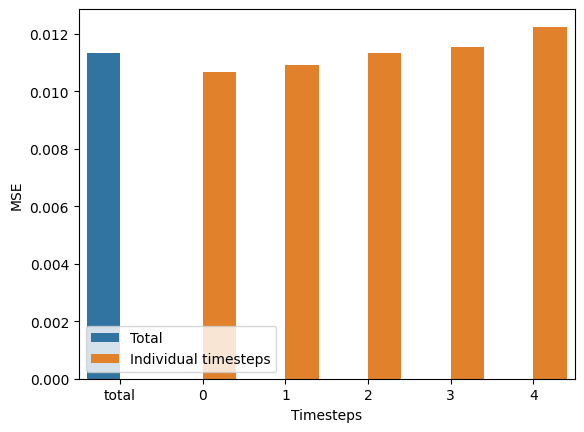

In [25]:
df_metrics = pd.DataFrame.from_dict(all_data)
df_metrics["Is_Total"] = np.where(df_metrics["Timesteps"] == "total","Total","Individual timesteps")
sns.barplot(x="Timesteps",y="MSE",data=df_metrics,hue="Is_Total")
plt.legend(loc="lower left")

Below we get to see how our model performs --- on the x axis we have the time, on the y axis we have normalized permanence; each plot corresponds to the permanence in a given grid cell. We should highlight here that how it captures broad trends and also some finer details of mobility.

A hopeful aspect of this approach is that the time to train it was scarce and its development can be considerably expanded - including more sources of data, from known traffic disruptions to strikes and the location of local and national landmarks, could be the key to further unlocking the accurate modelling of permanence data. Additionally, such a framework - temporal GCNs - has the added advantage of presenting an easily deployable and quick product.

Data points: (165,)


<Axes: >

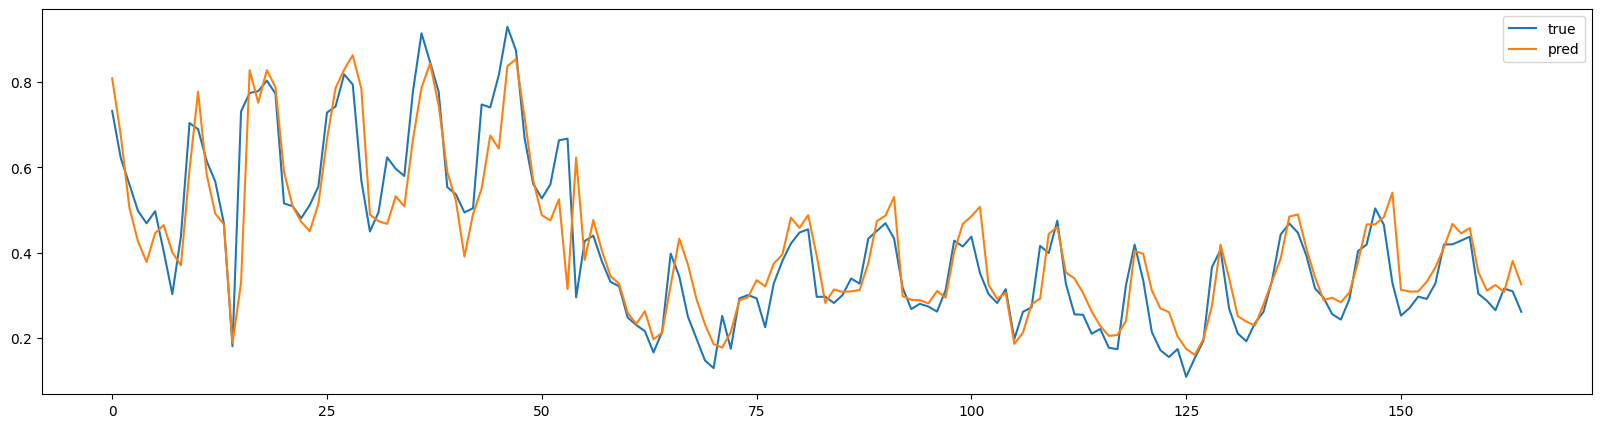

In [26]:
### Plot predicted signal and ground truth

node = 100 # select node
timestep = -1 # select period of prediction (from 0 to periods-1)
preds = np.asarray([pred[node][timestep].detach().cpu().numpy() for pred in predictions])
labs  = np.asarray([label[node][timestep].cpu().numpy() for label in test_labels])
print("Data points:", preds.shape)

plt.figure(figsize=(20,5))
sns.lineplot(data=labs, label="true")
sns.lineplot(data=preds, label="pred")

Data points: (165,)


<Axes: >

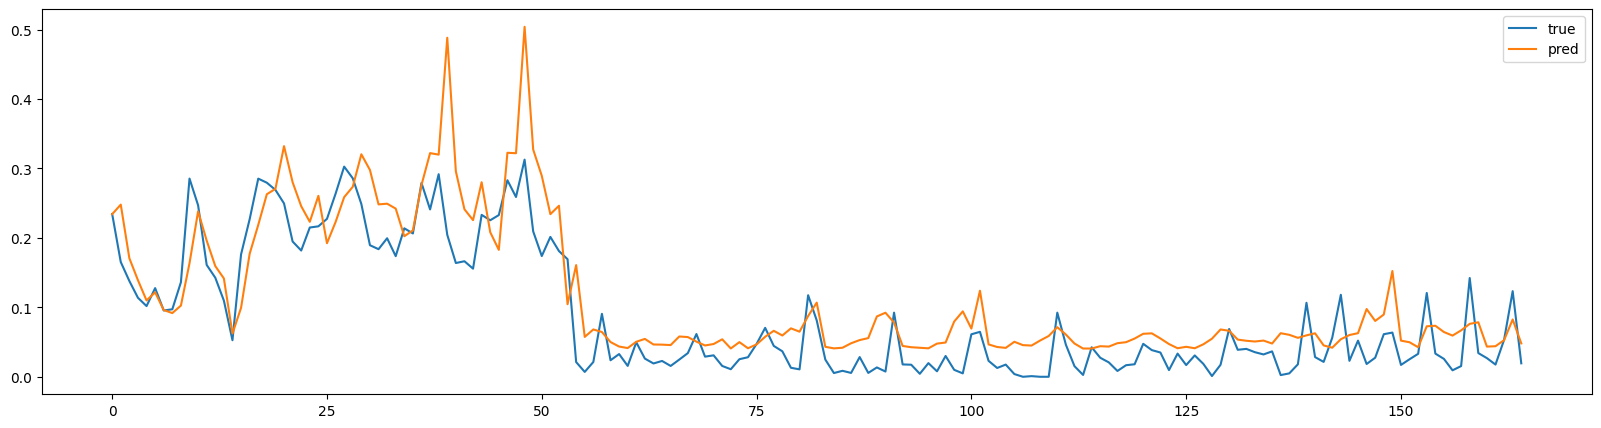

In [27]:
node = 75 # select node
timestep = -1 # select period of prediction (from 0 to periods-1)
preds = np.asarray([pred[node][timestep].detach().cpu().numpy() for pred in predictions])
labs  = np.asarray([label[node][timestep].cpu().numpy() for label in test_labels])
print("Data points:", preds.shape)

plt.figure(figsize=(20,5))
sns.lineplot(data=labs, label="true")
sns.lineplot(data=preds, label="pred")

## 🖼️ Visualisations

<Axes: xlabel='Time of day', ylabel='C1'>

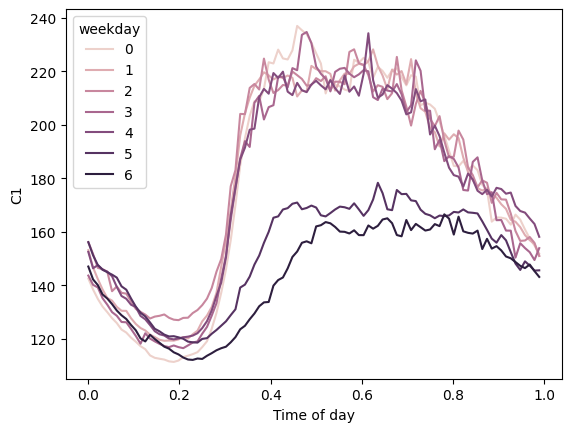

In [28]:
sns.lineplot(x="Time of day",y="C1",data=data_to_observe,hue="weekday")

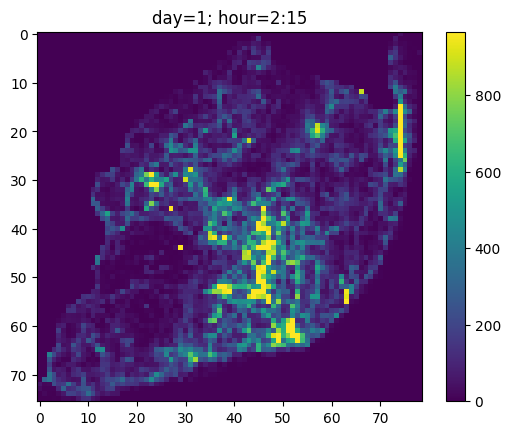

In [29]:
for i in range(0,time_steps):
    pl.imshow(data_array[starting_time_step + int(i*time_step_size),0,::-1],
              vmin=0,vmax=np.quantile(data_array[:,0,:,:],0.99))
    plt.colorbar()
    minutes_day = (i % 96) / 96 * (24*60)
    hours = int(minutes_day // 60)
    minutes = int(minutes_day % 60)
    day_of_month = i // 96 + 1
    plt.title("day={}; hour={}:{}".format(day_of_month,hours,minutes))
    display.clear_output(wait=True)
    display.display()
    plt.show()
    time.sleep(0.001)

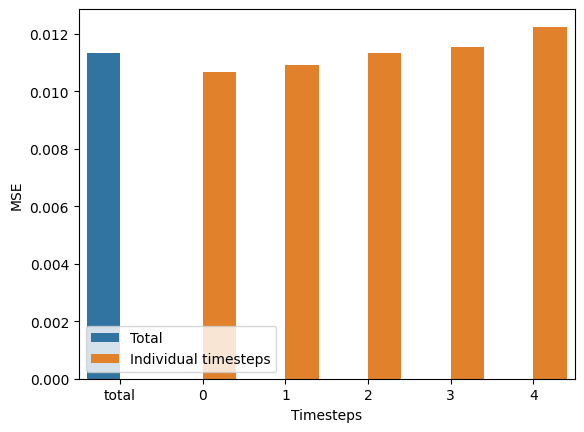

In [30]:
sns.barplot(x="Timesteps",y="MSE",data=df_metrics,hue="Is_Total")
plt.legend(loc="lower left")

<Axes: >

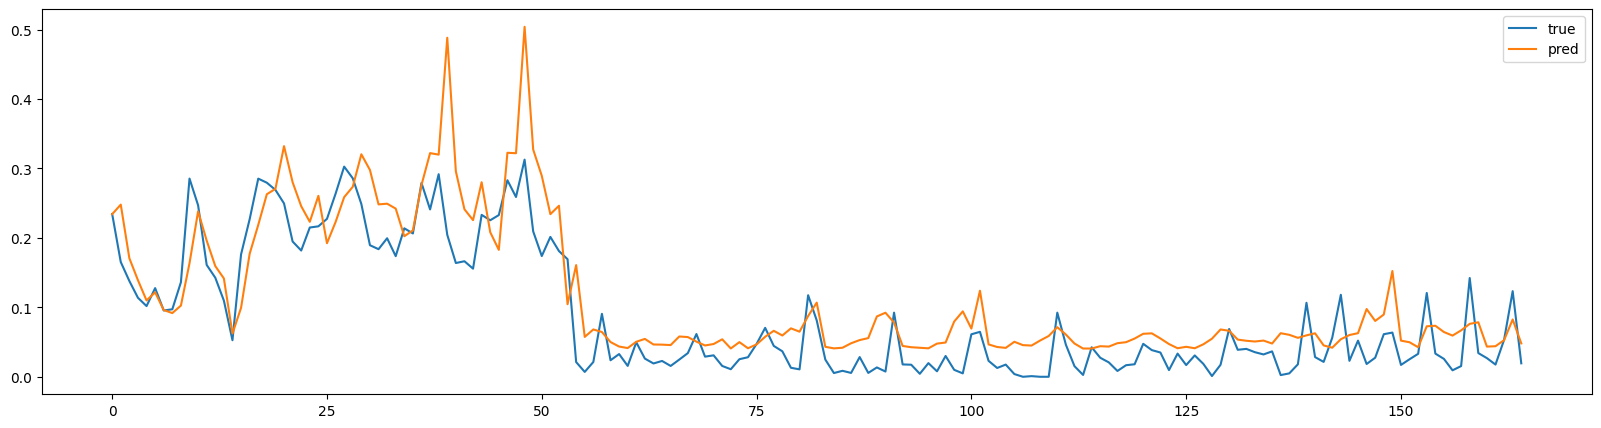

In [31]:
### Plot predicted signal and ground truth

node = 100 # select node
timestep = -1 # select period of prediction (from 0 to periods-1)
preds = np.asarray([pred[node][timestep].detach().cpu().numpy() for pred in predictions])
labs  = np.asarray([label[node][timestep].cpu().numpy() for label in test_labels])
print("Data points:", preds.shape)

plt.figure(figsize=(20,5))
sns.lineplot(data=labs, label="true")
sns.lineplot(data=preds, label="pred")

## 👓 References

* https://dadosabertos.cm-lisboa.pt/dataset/rede-viaria-escala-1-20000/resource/616c663f-b951-4fe7-aa6c-d1e5050ef0f7
* https://www.mdpi.com/2220-9964/10/7/485
* https://www.kaggle.com/code/elmahy/a3t-gcn-for-traffic-forecasting